In [2]:
import shap
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from joblib import load
from data_preprocess import preprocess_data

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female

In [9]:
xgb_model = load('C:/Users/zen/Documents/-- four/s2/FYP I/XAl-on-healthcare-diagnostics/version_3.0/non-xai/XGBoost_model.pkl')
lgbm_model = load('C:/Users/zen/Documents/-- four/s2/FYP I/XAl-on-healthcare-diagnostics/version_3.0/non-xai/lightgbm_model.pkl')
#ensemble_predict = load("C:/Users/zen/Documents/-- four/s2/FYP I/XAl-on-healthcare-diagnostics/version_3.0/non-xai/ensemble_model.pkl")

def ensemble_predict(X):
    if X is None or X.empty:
        raise ValueError("Input data is not defined or is empty.")
    xgb_pred = xgb_model.predict_proba(X)[:, 1]
    lgbm_pred = lgbm_model.predict_proba(X)[:, 1]
    ensemble_pred = (xgb_pred + lgbm_pred) / 2
    return ensemble_pred

<font color="bluegrey" size=+1.0><b>Preprocess</b></font>

In [10]:
file_path = 'C:/Users/zen/Documents/-- four/s2/FYP I/XAl-on-healthcare-diagnostics/version_3.0/healthcare-dataset-stroke-data.csv'
data = pd.read_csv(file_path)

data['bmi'] = data['bmi'].fillna(data['bmi'].mean())

data = data.drop(columns=['id'])

target_column = 'stroke'

# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_columns = ['age', 'avg_glucose_level', 'bmi']

X_train_processed, X_test_processed, pipeline = preprocess_data(X_train, X_test, categorical_columns, numerical_columns)

Processed Training Data Shape: (4088, 18)
Processed Testing Data Shape: (1022, 18)


<font color="bluegrey" size=+1.0><b>Ensemble (XGBoost + LightGBM)</b></font>

100%|██████████| 1022/1022 [06:58<00:00,  2.44it/s]


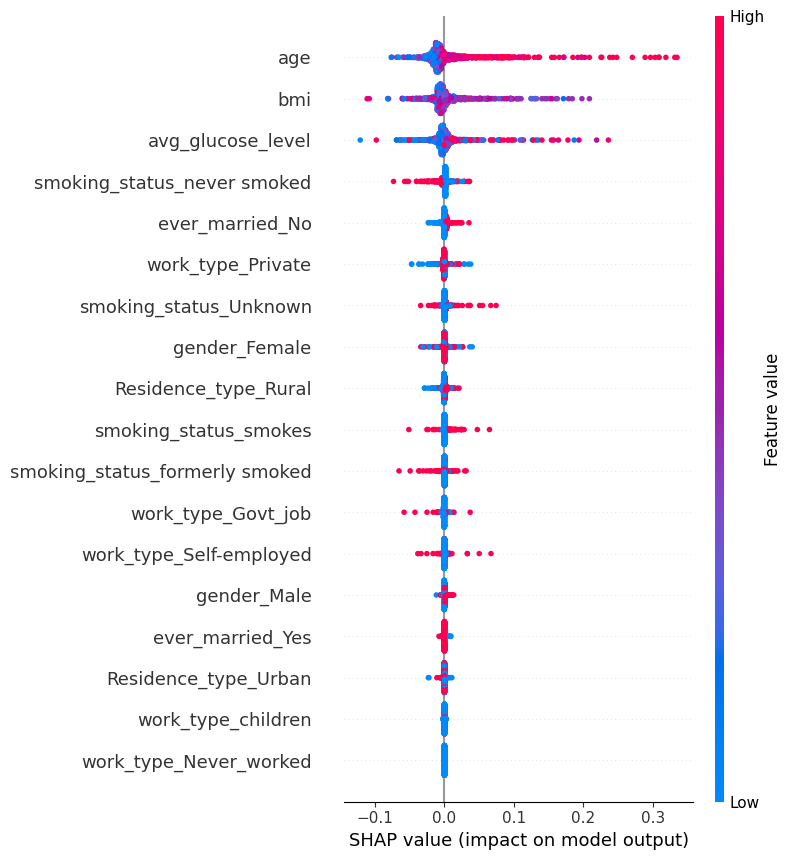

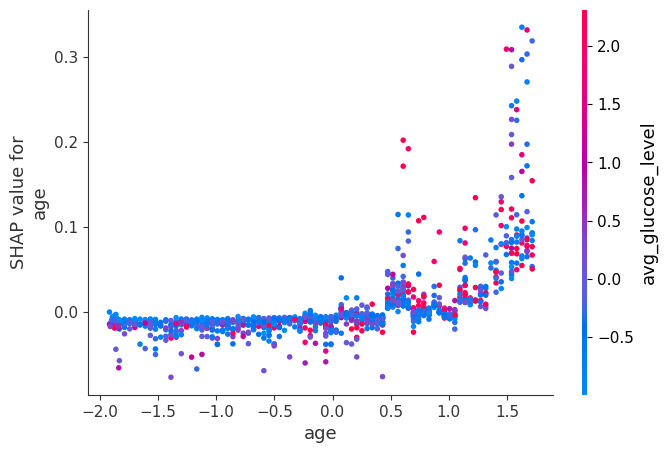

In [14]:
def predict_fn_ensemble(X):
    xgb_pred = xgb_model.predict_proba(X)[:, 1]
    lgbm_pred = lgbm_model.predict_proba(X)[:, 1]
    ensemble_pred = (xgb_pred + lgbm_pred) / 2
    return ensemble_pred

background_kmeans = shap.kmeans(X_train_processed, 50)  # Create 50 clusters

explainer_ensemble = shap.KernelExplainer(predict_fn_ensemble, background_kmeans)

shap_values_ensemble = explainer_ensemble.shap_values(X_test_processed)

processed_feature_names = [
    'age', 'avg_glucose_level', 'bmi', 'gender_Female', 'gender_Male', 
    'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 
    'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
    'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 
    'smoking_status_Unknown', 'smoking_status_formerly smoked', 
    'smoking_status_never smoked', 'smoking_status_smokes'
]

feature_names = processed_feature_names

shap.summary_plot(shap_values_ensemble, X_test_processed, feature_names=feature_names)

# Partial Dependence Plot (PDP)
shap.dependence_plot('age', shap_values_ensemble, X_test_processed, feature_names=feature_names)

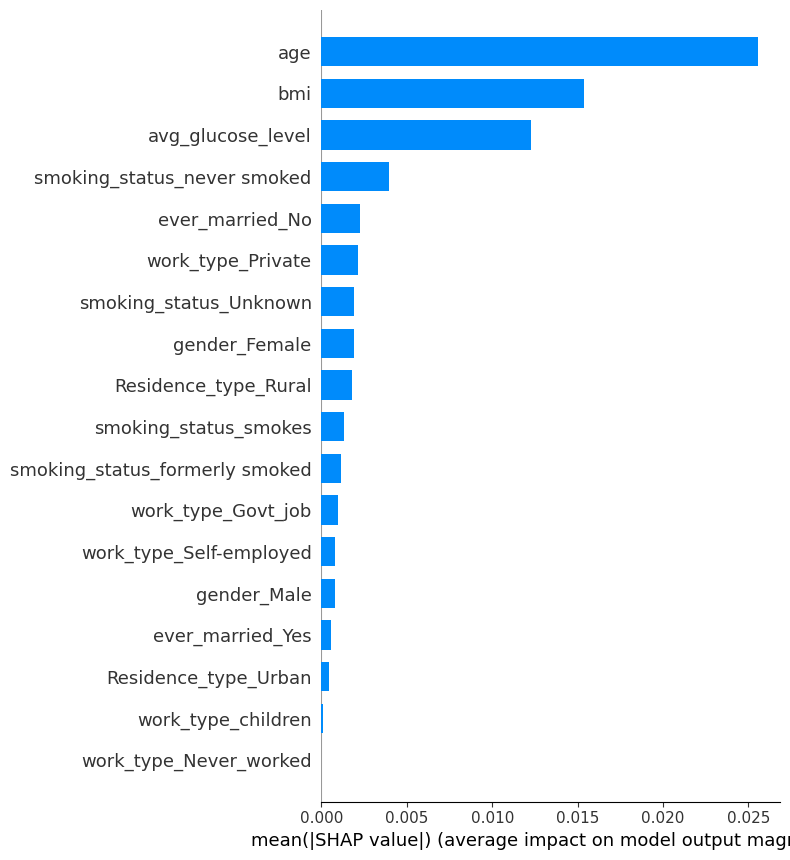

In [15]:
# Feature importance for Ensemble models
shap.summary_plot(shap_values_ensemble, X_test_processed, feature_names=feature_names, plot_type="bar")